# Read Data

### (Pretty much depends on the data format, I am using Amazon review data for this demo)

In [2]:
import pandas as pd
import gzip

In [3]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l)
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
# I only sampled 100,000 data here to save time, in actual project, we always feed in all the data
pet_df = getDF('C:/Users/ZachXiong/Downloads/reviews_Pet_Supplies_5.json.gz')
df = pet_df.rename(columns={'reviewText':'text'}).sample(n=100000, random_state=42).reset_index()
df.head()

,index,reviewerID,asin,reviewerName,helpful,text,overall,summary,unixReviewTime,reviewTime
0,121560,A2G5IFYYHFIQNB,B004QJYZ52,A Navy Vet...VT town,"[1, 2]","Owning boxer dogs for a number of years, I was...",5.0,~~Outstanding for large dogs~~,1399248000,"05 5, 2014"
1,11293,A3TLMYKATDGITX,B0002AR19Q,"jogre ""jl_depot""","[1, 1]",I've gotten a lot of good use out of this prod...,4.0,Best Brush I've Used,1396224000,"03 31, 2014"
2,118621,A3H08VUFKT5DIK,B004H22KZK,"Lola 48 ""Dazzleyou""","[3, 3]",My older dog has been plagued with urinary tra...,5.0,Stops Urinary tract infections,1345507200,"08 21, 2012"
3,51171,A2FZRBEARWKCTZ,B000M958WO,J. Brown,"[0, 0]",I got these as a gift for a foster cat's kitte...,4.0,cute mice,1377475200,"08 26, 2013"
4,143187,A3DF6HB16AWD0I,B0082387BG,DC,"[2, 3]",I was using Frontline Plus on my miniature Sch...,5.0,Worked great!!,1394928000,"03 16, 2014"


# Topic Modeling

In [5]:
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZachXiong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# TO DO: Change the topic numbers
topic_n = 10
review = df
# simple text preprocessing
review['text_processed_'] = review['text'].map(lambda x: re.sub('[,\.!?]', '', x))
review['text_processed_'] = review['text_processed_'].map(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
nltk.download('words')
words = set(nltk.corpus.words.words())
review['text_processed_'] = review['text_processed_'].map(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = review.text_processed_.values.tolist()
data_words = list(sent_to_words(data))  
    
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
    
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
n_topics = topic_n
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,minimum_probability=0)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ZachXiong\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


[(0,
  '0.034*"tank" + 0.030*"water" + 0.026*"filter" + 0.022*"fish" + 0.016*"work" '
  '+ 0.011*"gallon" + 0.010*"get" + 0.010*"great" + 0.010*"well" + '
  '0.010*"aquarium"'),
 (1,
  '0.038*"cat" + 0.026*"get" + 0.020*"go" + 0.014*"put" + 0.012*"time" + '
  '0.012*"take" + 0.009*"come" + 0.009*"door" + 0.009*"bed" + 0.008*"try"'),
 (2,
  '0.066*"dog" + 0.045*"small" + 0.044*"size" + 0.023*"great" + 0.022*"large" '
  '+ 0.020*"big" + 0.019*"well" + 0.017*"love" + 0.016*"good" + 0.016*"easy"'),
 (3,
  '0.066*"food" + 0.049*"dog" + 0.034*"eat" + 0.015*"give" + 0.014*"good" + '
  '0.013*"cat" + 0.012*"treat" + 0.012*"feed" + 0.010*"dry" + 0.010*"love"'),
 (4,
  '0.046*"water" + 0.030*"bowl" + 0.020*"cat" + 0.017*"clean" + 0.014*"get" + '
  '0.013*"fountain" + 0.011*"easy" + 0.010*"drink" + 0.008*"time" + '
  '0.008*"fill"'),
 (5,
  '0.075*"dog" + 0.023*"work" + 0.020*"get" + 0.017*"well" + 0.016*"collar" + '
  '0.015*"hair" + 0.014*"brush" + 0.011*"great" + 0.010*"use" + 0.010*"tooth"'),

In [8]:
# Compute Coherence Score (I used "u_mass" here to save time, if the data was not to large, try to use "c_v")
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Coherence Score:  -1.9535635731186036


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=20, step=1)

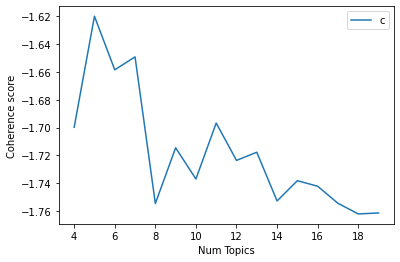

In [10]:
# Show graph
limit=20; start=4; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
coherence_values

[-1.6997823253628837,
 -1.6201605625506208,
 -1.6585540709873055,
 -1.6492955614372196,
 -1.7544621263607718,
 -1.7144908996782207,
 -1.736854368663002,
 -1.6967349455713678,
 -1.7235321822470115,
 -1.7176777185705308,
 -1.7526162218671928,
 -1.7380702063414608,
 -1.7420733946348383,
 -1.7542874521833567,
 -1.7619089062784363,
 -1.7612279054475666]

In [12]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [13]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

In [14]:
lda_topic = df_topic_sents_keywords["Dominant_Topic"].astype(int).tolist()
df['lda_topic'] = lda_topic

In [15]:
df[['text', 'overall', 'text_processed_', 'lda_topic']].head()

,text,overall,text_processed_,lda_topic
0,"Owning boxer dogs for a number of years, I was...",5.0,boxer dogs for a number of I was searching for...,5
1,I've gotten a lot of good use out of this prod...,4.0,I ' gotten a lot of good use out of this produ...,5
2,My older dog has been plagued with urinary tra...,5.0,My older dog been plagued with urinary tract t...,8
3,I got these as a gift for a foster cat's kitte...,4.0,I got these as a gift for a foster cat ' s The...,6
4,I was using Frontline Plus on my miniature Sch...,5.0,I was Plus on my miniature Schnauzer cross but...,8


In [18]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\ZachXiong\anaconda3\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.153959 -0.014762       1        1  14.942901
1     -0.029859 -0.066066       2        1  13.150400
6      0.080187  0.068636       3        1  12.149566
8      0.136112 -0.047087       4        1  11.729038
5      0.068786  0.045478       5        1   9.858909
2      0.012819  0.207269       6        1   9.640423
7     -0.029134 -0.078128       7        1   8.566205
9     -0.229780  0.112901       8        1   6.734180
4     -0.090077 -0.141949       9        1   6.719456
0     -0.073012 -0.086292      10        1   6.508922, topic_info=        Term          Freq         Total Category  logprob  loglift
3        dog  79098.000000  79098.000000  Default  30.0000  30.0000
149     food  29367.000000  29367.000000  Default  29.0000  29.0000
114      toy  17435.000000  17435.000000  Default  28.0000  28.0000
395   litter  14007.000000  14007.000000  Default  27.0000  27.0000
241    water  14811.000000  14811.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
66      come    941.724809  14012.594639  Topic10  -5.3084   0.0320
24        go    984.377667  25221.085116  Topic10  -5.2641  -0.5114
46   product    956.638134  22711.155252  Topic10  -5.2927  -0.4352
12      time    956.594901  22827.349931  Topic10  -5.2927  -0.4403
38      much    943.654322  18812.558687  Topic10  -5.3063  -0.2605

[766 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
900       1  0.068738     absorb
900       5  0.044189     absorb
900       7  0.839585     absorb
900      10  0.044189     absorb
2739      4  0.164475  absorbent
...     ...       ...        ...
115       8  0.001611       year
115       9  0.028989       year
115      10  0.017358       year
4590      6  0.972732       yoga
4828      2  0.993851      yummy

[1927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 7, 9, 6, 3, 8, 10, 5, 1])